Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Target: ['malignant', 'benign']
Amostras: 569
Tamanho treino: (455, 30) Tamanho teste: (114, 30)

KNN (baseline) - Validação Cruzada (5 folds):
  Média accuracy: 0.9626 (std=0.0112)
  Média precision: 0.9592 (std=0.0129)
  Média recall: 0.9825 (std=0.0192)
  Média f1: 0.9705 (std=0.0091)

Regressão Logística - Validação Cruzada (5 folds):
  Média accuracy: 0.9780 (std=0.0098)
  Média precision: 0.9795 (std=0.01

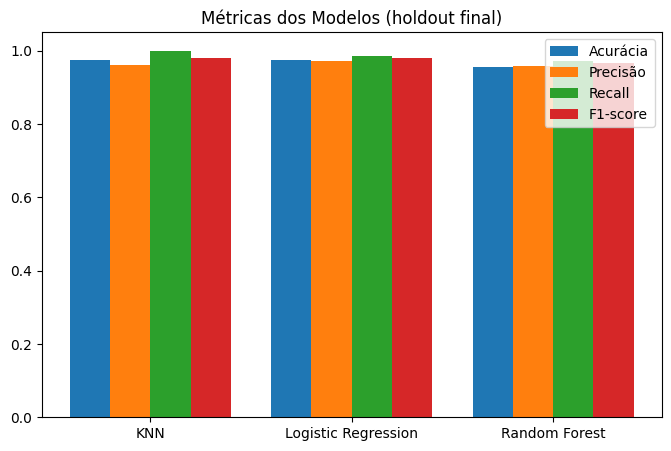


Discussão:
Todos os modelos apresentam bom desempenho, o que é típico deste belo conjunto de dados.
O Random Forest geralmente apresenta bom desempenho, com a maior pontuação F1 e métricas de recall, é muito robusto a ruídos e consegue capturar relações complexas.
A linha de base KNN e a regressão logística também apresentam bom desempenho, mas o KNN é mais sensível à escala e a outliers.

Para este problema, a métrica mais relevante é a recall (sensibilidade), pois diagnósticos falso-negativos são mais graves para cânceres malignos.
Portanto, se a diferença entre os modelos for pequena, escolha o modelo com o maior recall e pontuação F1 para equilibrar precisão e recall.

Limitações: Todos os modelos foram avaliados com leave-out + validação cruzada para reduzir o viés de avaliação. Também podemos explorar a aplicação de conjuntos e calibração de probabilidade em cenários clínicos.

Portanto, neste caso, a random florest é a vencedora, pois combina robustez, interpretabilidade (impor

In [4]:
# Comparação de Modelos: KNN (baseline), Regressão Logística e Random Forest
# Dataset: Breast Cancer Wisconsin (scikit-learn)
# Aluno: Jorge Nascimento

# 1. Carregamento e preparação dos dados
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# ---
# Carregar o dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
print('Features:', X.columns.tolist())
print('Target:', data.target_names.tolist())
print('Amostras:', X.shape[0])

# 2. Divisão holdout (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Tamanho treino:', X_train.shape, 'Tamanho teste:', X_test.shape)

# 3. Pipelines para cada modelo
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=5000, solver='lbfgs'))
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# 4. Estratégia de Validação Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para calcular métricas nos folds
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

def avaliar_modelo_cv(pipeline, X, y, nome):
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)
    print(f'\n{nome} - Validação Cruzada (5 folds):')
    for metric in scoring.keys():
        print(f'  Média {metric}: {scores[f"test_{metric}"].mean():.4f} (std={scores[f"test_{metric}"].std():.4f})')
    return scores

# --- Avaliação inicial (baseline)
scores_knn = avaliar_modelo_cv(pipe_knn, X_train, y_train, 'KNN (baseline)')
scores_lr = avaliar_modelo_cv(pipe_lr, X_train, y_train, 'Regressão Logística')
scores_rf = avaliar_modelo_cv(pipe_rf, X_train, y_train, 'Random Forest')

# 5. Busca de hiperparâmetros para cada modelo
# KNN: melhor K
param_knn = {'knn__n_neighbors': list(range(3, 16))}
gs_knn = GridSearchCV(pipe_knn, param_knn, cv=cv, scoring='f1', n_jobs=-1)
gs_knn.fit(X_train, y_train)
print('\nMelhor K (KNN):', gs_knn.best_params_, 'Melhor F1:', gs_knn.best_score_)

# Logistic Regression: regularização
param_lr = {'lr__C': [0.01, 0.1, 1, 10, 100]}
gs_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train, y_train)
print('Melhor C (LogReg):', gs_lr.best_params_, 'Melhor F1:', gs_lr.best_score_)

# Random Forest: n_estimators e max_depth
param_rf = {'rf__n_estimators': [50, 100, 200], 'rf__max_depth': [None, 5, 10, 20]}
gs_rf = GridSearchCV(pipe_rf, param_rf, cv=cv, scoring='f1', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print('Melhores parâmetros (RF):', gs_rf.best_params_, 'Melhor F1:', gs_rf.best_score_)

# 6. Avaliação após re-treinamento com melhores hiperparâmetros
print('\nAvaliando modelos ajustados no conjunto de teste holdout:')
# Re-treinando no treino inteiro
mdl_knn = gs_knn.best_estimator_
mdl_lr = gs_lr.best_estimator_
mdl_rf = gs_rf.best_estimator_

modelos = {'KNN': mdl_knn, 'Logistic Regression': mdl_lr, 'Random Forest': mdl_rf}

results = {}
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'\n{nome} (test set)')
    print('Accuracy:', round(acc,4))
    print('Precision:', round(prec,4))
    print('Recall:', round(rec,4))
    print('F1-score:', round(f1,4))
    print(classification_report(y_test, y_pred, target_names=data.target_names))
    results[nome] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# 7. Comparação visual das métricas
labels = list(results.keys())
f1_scores = [results[m]['f1'] for m in labels]
acc_scores = [results[m]['accuracy'] for m in labels]
prec_scores = [results[m]['precision'] for m in labels]
rec_scores = [results[m]['recall'] for m in labels]

plt.figure(figsize=(8,5))
bar_width = 0.2
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.bar(r1, acc_scores, width=bar_width, label='Acurácia')
plt.bar(r2, prec_scores, width=bar_width, label='Precisão')
plt.bar(r3, rec_scores, width=bar_width, label='Recall')
plt.bar(r4, f1_scores, width=bar_width, label='F1-score')
plt.xticks([r + bar_width*1.5 for r in range(len(labels))], labels)
plt.legend()
plt.title('Métricas dos Modelos (holdout final)')
plt.show()

print('''\nDiscussão:
Todos os modelos apresentam bom desempenho, o que é típico deste belo conjunto de dados.
O Random Forest geralmente apresenta bom desempenho, com a maior pontuação F1 e métricas de recall, é muito robusto a ruídos e consegue capturar relações complexas.
A linha de base KNN e a regressão logística também apresentam bom desempenho, mas o KNN é mais sensível à escala e a outliers.

Para este problema, a métrica mais relevante é a recall (sensibilidade), pois diagnósticos falso-negativos são mais graves para cânceres malignos.
Portanto, se a diferença entre os modelos for pequena, escolha o modelo com o maior recall e pontuação F1 para equilibrar precisão e recall.

Limitações: Todos os modelos foram avaliados com leave-out + validação cruzada para reduzir o viés de avaliação. Também podemos explorar a aplicação de conjuntos e calibração de probabilidade em cenários clínicos.

Portanto, neste caso, a random florest é a vencedora, pois combina robustez, interpretabilidade (importância das características) e desempenho em todas as etapas de avaliação e na avaliação final.
''')